In [1]:
#%%
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#%% Prepare dataset

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Model / data parameters
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1::]
print(input_shape)

(28, 28, 1)


In [3]:
#%% Prepare data for siamese network

def prepare_dataset(x, y, n=10):
    self_class_max_num = n * (num_classes - 1)
    
    pos_samples = []
    neg_samples = []
    
    def getClassIdx(y, class_val):
        class_idx = np.squeeze(np.argwhere(y == class_val))
        np.random.shuffle(class_idx)
        return class_idx
    
    for class_val in range(num_classes):
        # Get idxs of the class from the dataset
        class_idx = getClassIdx(y, class_val)
        
        # Get first pair
        a = x[class_idx[0]]
        
        # Get positive samples
        for i in range(self_class_max_num):
            b = x[class_idx[1+i]]
            pos_samples.append((a, b))
            
        # Get negative samples
        for temp in range(num_classes):
            
            # Only get negative samples from different class
            if temp == class_val:
                continue
            
            # To keep it the samples to be balanced between pos & neg samples
            # Limit number of samples per class
            diff_class_max_num = n
            diff_class_idx = getClassIdx(y, temp)
            
            for i in range(diff_class_max_num):
                b = x[diff_class_idx[i]]
                neg_samples.append((a, b))
                
    pos_array = np.array(pos_samples)
    neg_array = np.array(neg_samples)
    pos_label = np.ones(shape=len(pos_array)).astype(np.float32)
    neg_label = np.zeros(shape=len(neg_array)).astype(np.float32)
    
    siam_inputs = np.append(pos_array, neg_array, axis=0)
    siam_labels = np.append(pos_label, neg_label, axis=0)
    
    # Shuffle dataset
    shuffle_idx = np.arange(0, len(siam_labels))
    np.random.shuffle(shuffle_idx)
    siam_inputs = siam_inputs[shuffle_idx]
    siam_labels = siam_labels[shuffle_idx]
    
    return siam_inputs, siam_labels
    
siam_x_train, siam_y_train = prepare_dataset(x_train, y_train, n=10)
siam_x_test, siam_y_test = prepare_dataset(x_test, y_test, n=5)

print("Training dataset: {}".format(siam_x_train.shape))
print("Testing dataset: {}".format(siam_x_test.shape))

Training dataset: (1800, 2, 28, 28, 1)
Testing dataset: (900, 2, 28, 28, 1)


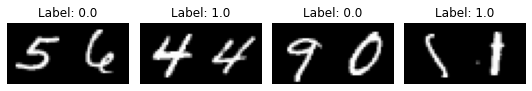

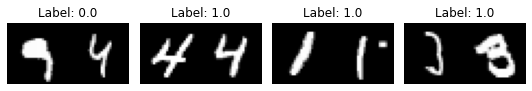

In [4]:
# %% Pair visualization

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

visualize(siam_x_train[:-1], siam_y_train[:-1], to_show=4, num_col=4)
visualize(siam_x_test[:-1], siam_y_test[:-1], to_show=4, num_col=4)

Model: "Siamese"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 10)           5318        input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           Embedding[0][0]            

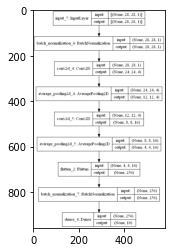

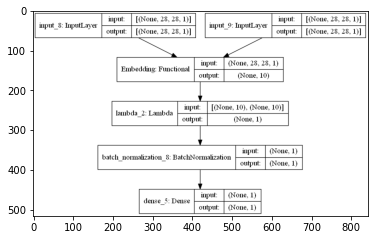

In [7]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(10, activation="tanh")(x)
embedding_network = tf.keras.Model(input, x, name='Embedding')

dot_img_file = 'siamese-embedding.png'
tf.keras.utils.plot_model(embedding_network, to_file=dot_img_file, show_shapes=True)
plt.figure()
plt.imshow(plt.imread(dot_img_file))

input_1 = tf.keras.layers.Input(shape=input_shape)
input_2 = tf.keras.layers.Input(shape=input_shape)

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer, name='Siamese')

dot_img_file = 'siamese-main.png'
tf.keras.utils.plot_model(siamese, to_file=dot_img_file, show_shapes=True)
plt.figure()
plt.imshow(plt.imread(dot_img_file))

print(siamese.summary())

In [6]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [7]:
margin = 1
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])

In [8]:
epochs = 20
batch_size = 16

history = siamese.fit(
    [siam_x_train[:, 0], siam_x_train[:, 1]],
    siam_y_train,
    validation_data=([siam_x_test[:, 0], siam_x_test[:, 1]], siam_y_test),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
113/113 [==============================] - 7s 21ms/step - loss: 0.1551 - accuracy: 0.7994 - val_loss: 0.1523 - val_accuracy: 0.8000
Epoch 2/20
113/113 [==============================] - 2s 16ms/step - loss: 0.1183 - accuracy: 0.8750 - val_loss: 0.1368 - val_accuracy: 0.8167
Epoch 3/20
113/113 [==============================] - 2s 14ms/step - loss: 0.1036 - accuracy: 0.8861 - val_loss: 0.1067 - val_accuracy: 0.8656
Epoch 4/20
113/113 [==============================] - 2s 14ms/step - loss: 0.0889 - accuracy: 0.8978 - val_loss: 0.1132 - val_accuracy: 0.8511
Epoch 5/20
113/113 [==============================] - 2s 14ms/step - loss: 0.0797 - accuracy: 0.9094 - val_loss: 0.1144 - val_accuracy: 0.8433
Epoch 6/20
113/113 [==============================] - 2s 15ms/step - loss: 0.0730 - accuracy: 0.9189 - val_loss: 0.1051 - val_accuracy: 0.8467
Epoch 7/20
113/113 [==============================] - 2s 14ms/step - loss: 0.0659 - accuracy: 0.9189 - val_loss: 0.0943 - val_accuracy: 0.8722

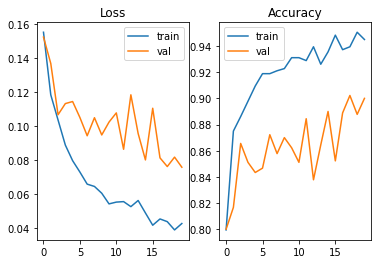

In [9]:
#%% Training history visualization
plt.figure()
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'])

In [10]:
#%% Model evaluation
results = siamese.evaluate([siam_x_test[:, 0], siam_x_test[:, 1]], siam_y_test)
print("[loss | accuracy]: [{:.6f} | {:.2f}%]".format(results[0], results[1] * 100))

29/29 [==============================] - 0s 5ms/step - loss: 0.0758 - accuracy: 0.9000
[loss | accuracy]: [0.075845 | 90.00%]


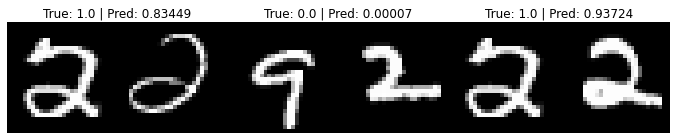

In [11]:
#%% Prediction
predictions = siamese.predict([siam_x_test[:, 0], siam_x_test[:, 1]])
visualize(siam_x_test, siam_y_test, to_show=3, predictions=predictions, test=True)